In [1]:
#!curl http://localhost:3000/export.php -o puppeteer.csv

=== XGBoost Classification Report (thresholded) ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       300
           1       0.98      0.98      0.98       301

    accuracy                           0.98       601
   macro avg       0.98      0.98      0.98       601
weighted avg       0.98      0.98      0.98       601


=== Random Forest Classification Report (thresholded) ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.97      0.97      0.97       301

    accuracy                           0.97       601
   macro avg       0.97      0.97      0.97       601
weighted avg       0.97      0.97      0.97       601



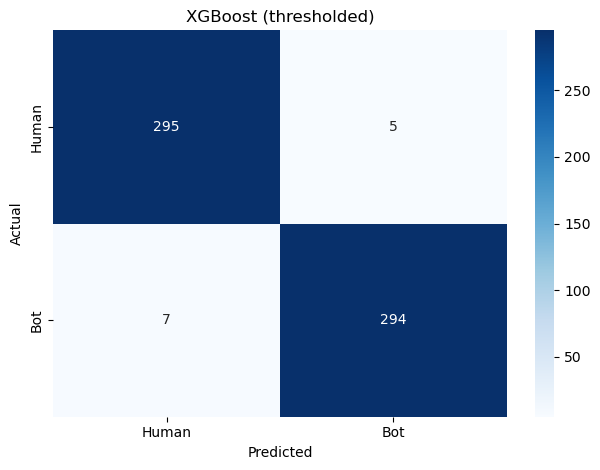

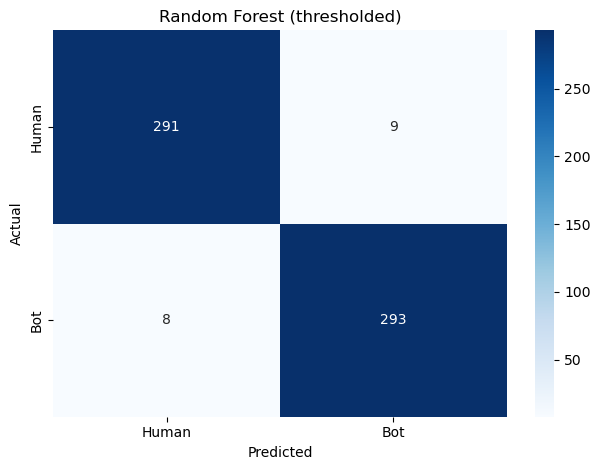


XGBoost kept 12 features:
 ['session_duration', 'avg_time_per_page', 'mouse_distance_avg', 'mouse_avg_speed', 'mouse_max_speed', 'mouse_sharp_turns', 'mouse_straight_movements', 'avg_scroll_depth', 'avg_scroll_speed', 'total_scrolls', 'total_clicks', 'avg_typing_speed']

Random Forest kept 13 features:
 ['session_duration', 'pages_visited', 'avg_time_per_page', 'mouse_distance_avg', 'mouse_avg_speed', 'mouse_max_speed', 'mouse_sharp_turns', 'mouse_straight_movements', 'avg_scroll_depth', 'avg_scroll_speed', 'total_scrolls', 'total_clicks', 'avg_typing_speed']


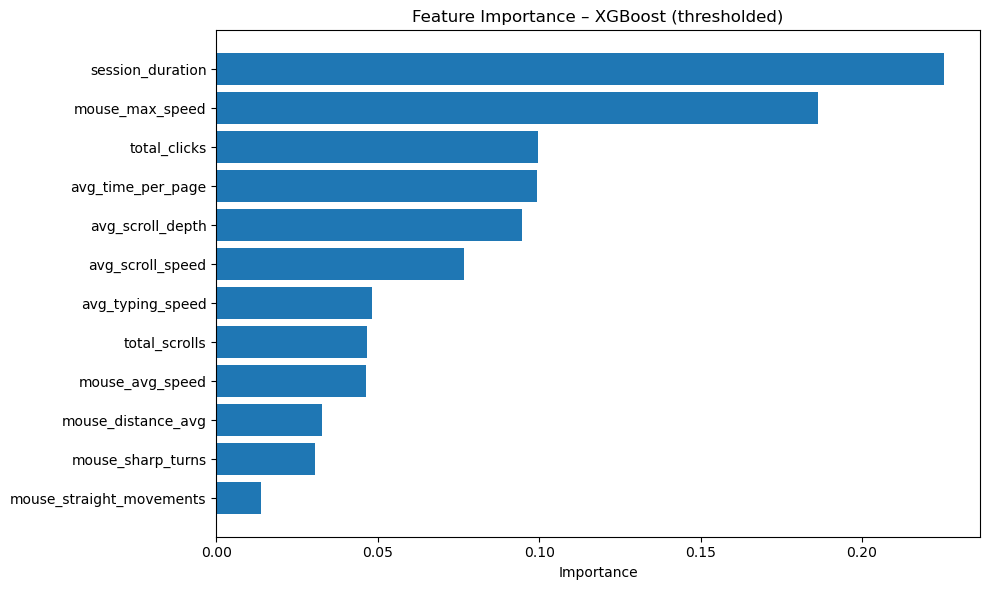

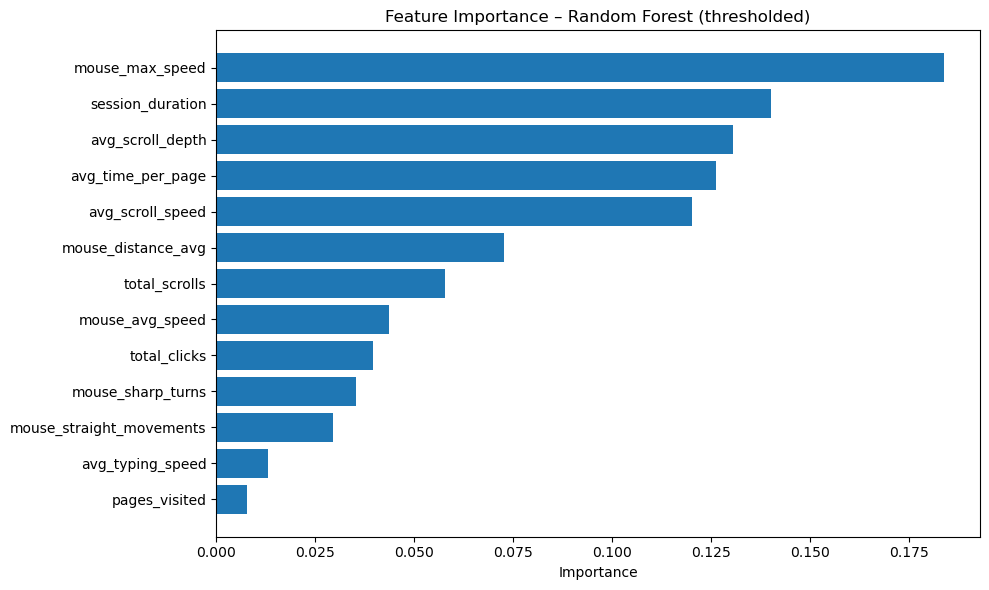

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Configurable thresholds for feature selection
XGB_FEATURE_THRESHOLD = 0.005
RF_FEATURE_THRESHOLD  = 0.005

# Load & label data
df_puppeteer = pd.read_csv("puppeteer.csv")
df_humans    = pd.read_csv("humans.csv")

df_puppeteer["label"] = 1
df_humans   ["label"] = 0

df = pd.concat([df_puppeteer, df_humans], ignore_index=True)

combined_df = df
winsor_cols = [
    "avg_time_per_page","total_scrolls","session_duration","avg_typing_speed",
    "total_clicks","avg_time_between_clicks","pages_visited","mouse_distance_avg",
    "mouse_sharp_turns","avg_scroll_depth","avg_scroll_speed","mouse_avg_speed",
    "mouse_straight_movements","mouse_max_speed","avg_shortcut_use"
]
# Only apply to columns that exist
for col in winsor_cols:
    if col in df.columns:
        upper = df[col].quantile(0.99)
        df[col] = np.minimum(df[col], upper)
combined_df.to_csv("combined_sessions.csv", index=False)

# Drop poorly recorded columns & keep only numeric features
df = df.drop(columns=[
    "session_id", "mouse_idle_time", "avg_time_between_clicks",
    #  "avg_time_per_page",
    # "total_scrolls",
    # "session_duration",
    # "avg_typing_speed",
    # "total_clicks",
    # "avg_time_between_clicks",
    # "pages_visited",
    # "mouse_distance_avg",
    #  "mouse_sharp_turns",
    #  "avg_scroll_depth",
    #  "avg_scroll_speed",
    # "mouse_avg_speed",
    # "mouse_straight_movements",
    # "mouse_max_speed",
    # "avg_shortcut_use"
], errors="ignore")
df = df.select_dtypes(include="number")
# Split features & target BEFORE any leakage-prone transforms
X = df.drop(columns="label")
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # optional because data is balanced
)

# Now winsorize using training-set percentiles only
winsor_cols = [
    "avg_time_per_page","total_scrolls","session_duration","avg_typing_speed",
    "total_clicks","avg_time_between_clicks","pages_visited","mouse_distance_avg",
    "mouse_sharp_turns","avg_scroll_depth","avg_scroll_speed","mouse_avg_speed",
    "mouse_straight_movements","mouse_max_speed","avg_shortcut_use"
]

for col in winsor_cols:
    if col in X_train.columns:
        # compute the 99th percentile on TRAIN only
        upper = X_train[col].quantile(0.99)
        # cap both train and val at that value
        X_train[col] = np.minimum(X_train[col], upper)
        X_val  [col] = np.minimum(X_val  [col], upper)

# compute class weight for imbalance
bot_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 1) Baseline XGBoost -> feature selection -> retrain
xgb_base = xgb.XGBClassifier(eval_metric="logloss", scale_pos_weight=bot_weight, n_estimators=200)
xgb_base.fit(X_train, y_train)

sel_xgb    = SelectFromModel(xgb_base, threshold=XGB_FEATURE_THRESHOLD, prefit=True)
X_tr_xgb   = sel_xgb.transform(X_train.values)
X_vl_xgb   = sel_xgb.transform(X_val.values)
cols_xgb   = X_train.columns[sel_xgb.get_support()]

xgb_sel = xgb.XGBClassifier(eval_metric="logloss", scale_pos_weight=bot_weight, n_estimators=200)
xgb_sel.fit(X_tr_xgb, y_train)

y_pred_xgb = xgb_sel.predict(X_vl_xgb)
print("=== XGBoost Classification Report (thresholded) ===")
print(classification_report(y_val, y_pred_xgb))

# 2) Baseline RF -> feature selection -> retrain
rf_base = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf_base.fit(X_train, y_train)

sel_rf  = SelectFromModel(rf_base, threshold=RF_FEATURE_THRESHOLD, prefit=True)
X_tr_rf = sel_rf.transform(X_train.values)
X_vl_rf = sel_rf.transform(X_val.values)
cols_rf = X_train.columns[sel_rf.get_support()]

rf_sel = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf_sel.fit(X_tr_rf, y_train)

y_pred_rf = rf_sel.predict(X_vl_rf)

# Separate by class
X_train_bots   = X_train[y_train == 1]
X_train_humans = X_train[y_train == 0]

# Compute stats per class
bot_stats = pd.DataFrame({
    "Bot_Mean": X_train_bots.mean(),
    "Bot_Median": X_train_bots.median()
})

human_stats = pd.DataFrame({
    "Human_Mean": X_train_humans.mean(),
    "Human_Median": X_train_humans.median()
})




print("\n=== Random Forest Classification Report (thresholded) ===")
print(classification_report(y_val, y_pred_rf))

# # Combine side-by-side
# stats_df = pd.concat([human_stats, bot_stats], axis=1).round(3)

# # Display
# print("\n=== Feature-wise Mean and Median (Humans vs Bots) ===")
# print(stats_df)
# Confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Human","Bot"], yticklabels=["Human","Bot"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_val, y_pred_xgb, "XGBoost (thresholded)")
plot_conf_matrix(y_val, y_pred_rf,  "Random Forest (thresholded)")

# Which features survived thresholding?
print(f"\nXGBoost kept {len(cols_xgb)} features:\n", list(cols_xgb))
print(f"\nRandom Forest kept {len(cols_rf)} features:\n", list(cols_rf))

# Feature-importance plots (sorted)
importances_xgb = xgb_sel.feature_importances_
feat_imp_xgb = pd.DataFrame({"feature": cols_xgb, "importance": importances_xgb})
feat_imp_xgb = feat_imp_xgb.sort_values("importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_xgb["feature"], feat_imp_xgb["importance"])
plt.xlabel("Importance")
plt.title("Feature Importance – XGBoost (thresholded)")
plt.tight_layout()
plt.show()

importances_rf = rf_sel.feature_importances_
feat_imp_rf = pd.DataFrame({"feature": cols_rf, "importance": importances_rf})
feat_imp_rf = feat_imp_rf.sort_values("importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_rf["feature"], feat_imp_rf["importance"])
plt.xlabel("Importance")
plt.title("Feature Importance – Random Forest (thresholded)")
plt.tight_layout()
plt.show()



Stage 1: 5-Fold CV F1 by n_estimators
 n_estimators  Random Forest F1  XGBoost F1
           50          0.969918    0.972378
          100          0.970696    0.971676
          200          0.971433    0.973074
          400          0.972140    0.972342
          800          0.969328    0.972357


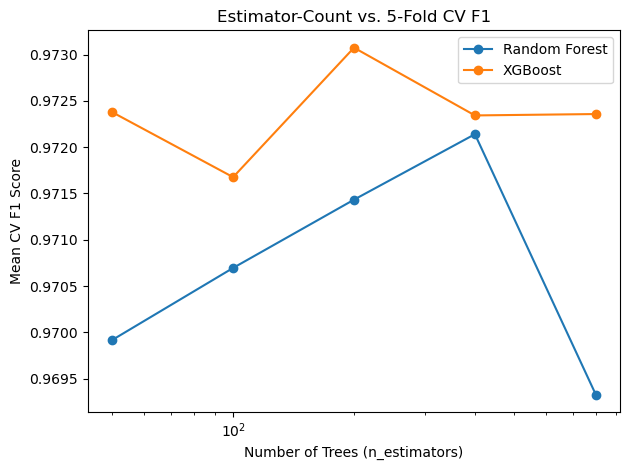


Stage 2: 5-Fold CV F1 by Feature-Importance Threshold
 threshold    RF F1   XGB F1
     0.001 0.971433 0.973074
     0.005 0.970711 0.973074
     0.010 0.966469 0.973074
     0.020 0.970005 0.971559
     0.050 0.951688 0.963173
     0.100 0.949871 0.812769


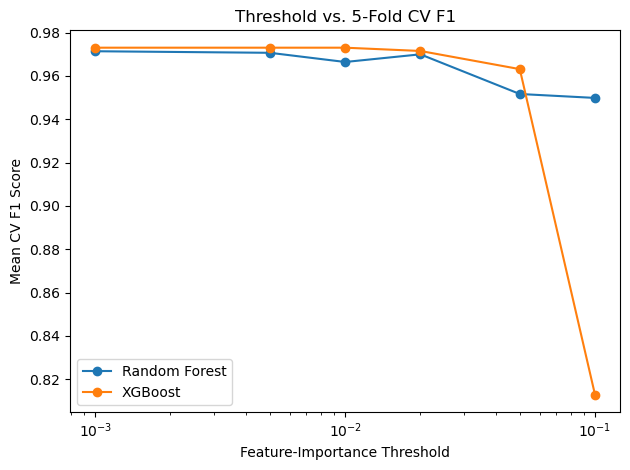

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# === 1. Load & preprocess data ===
df_puppeteer = pd.read_csv("puppeteer.csv")  # adjust path if needed
df_humans    = pd.read_csv("humans.csv")
df_puppeteer["label"] = 1
df_humans["label"]    = 0
df = pd.concat([df_puppeteer, df_humans], ignore_index=True)

# Drop IDs and non-numeric columns
df = df.drop(columns=["session_id", "mouse_idle_time", "avg_time_between_clicks"], errors="ignore")
df = df.select_dtypes(include="number")

# Split into features/target then into train/validation
X = df.drop(columns="label")
y = df["label"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Winsorize top 1% based on training set only
winsor_cols = [
    "avg_time_per_page","total_scrolls","session_duration","avg_typing_speed",
    "total_clicks","avg_time_between_clicks","pages_visited","mouse_distance_avg",
    "mouse_sharp_turns","avg_scroll_depth","avg_scroll_speed","mouse_avg_speed",
    "mouse_straight_movements","mouse_max_speed","avg_shortcut_use"
]
for col in winsor_cols:
    if col in X_train.columns:
        cap = X_train[col].quantile(0.99)
        X_train[col] = np.minimum(X_train[col], cap)
        X_val[col]   = np.minimum(X_val[col],   cap)

# Compute class weight for XGB
bot_weight = (y_train == 0).sum() / (y_train == 1).sum()

# === 2. Stage 1: Tune n_estimators with 5-fold CV ===
n_trees = [50, 100, 200, 400, 800]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores, xgb_scores = {}, {}

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, class_weight="balanced")
    rf_scores[n] = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1").mean()
    
    xgb = XGBClassifier(
        n_estimators=n, eval_metric="logloss",
        scale_pos_weight=bot_weight, random_state=42
    )
    xgb_scores[n] = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="f1").mean()

df_stage1 = pd.DataFrame({
    "n_estimators": n_trees,
    "Random Forest F1": [rf_scores[n] for n in n_trees],
    "XGBoost F1":       [xgb_scores[n] for n in n_trees]
})

print("Stage 1: 5-Fold CV F1 by n_estimators")
print(df_stage1.to_string(index=False))

# Plot estimator tuning
plt.figure()
plt.plot(df_stage1['n_estimators'], df_stage1['Random Forest F1'], marker='o')
plt.plot(df_stage1['n_estimators'], df_stage1['XGBoost F1'], marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean CV F1 Score")
plt.xscale("log")
plt.legend(["Random Forest", "XGBoost"])
plt.title("Estimator-Count vs. 5-Fold CV F1")
plt.tight_layout()
plt.show()

# === 3. Stage 2: Tune feature-importance threshold ===
thresholds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
rf_thr_scores, xgb_thr_scores = {}, {}

# Fit base models at best tree count (e.g., 400 if chosen)
best_n = 200
rf_base = RandomForestClassifier(n_estimators=best_n, random_state=42, class_weight="balanced").fit(X_train, y_train)
xgb_base = XGBClassifier(
    n_estimators=best_n, eval_metric="logloss",
    scale_pos_weight=bot_weight, random_state=42
).fit(X_train, y_train)

for t in thresholds:
    sel_rf = SelectFromModel(rf_base, threshold=t, prefit=True)
    X_tr_rf = sel_rf.transform(X_train.values)
    rf_thr_scores[t] = cross_val_score(rf_base, X_tr_rf, y_train, cv=cv, scoring="f1").mean()

    sel_xgb = SelectFromModel(xgb_base, threshold=t, prefit=True)
    X_tr_xgb = sel_xgb.transform(X_train.values)
    xgb_thr_scores[t] = cross_val_score(xgb_base, X_tr_xgb, y_train, cv=cv, scoring="f1").mean()

df_stage2 = pd.DataFrame({
    "threshold": thresholds,
    "RF F1":     [rf_thr_scores[t] for t in thresholds],
    "XGB F1":    [xgb_thr_scores[t] for t in thresholds]
})

print("\nStage 2: 5-Fold CV F1 by Feature-Importance Threshold")
print(df_stage2.to_string(index=False))

# Plot threshold tuning
plt.figure()
plt.plot(df_stage2['threshold'], df_stage2['RF F1'], marker='o')
plt.plot(df_stage2['threshold'], df_stage2['XGB F1'], marker='o')
plt.xlabel("Feature-Importance Threshold")
plt.ylabel("Mean CV F1 Score")
plt.xscale("log")
plt.legend(["Random Forest", "XGBoost"])
plt.title("Threshold vs. 5-Fold CV F1")
plt.tight_layout()
plt.show()


In [4]:
# Assuming the previous training script has run and you have y_val, y_pred_xgb, y_pred_rf available:

import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# Convert to arrays for indexing
y_true = y_val.values
y_pred_xgb_arr = np.array(y_pred_xgb)
y_pred_rf_arr  = np.array(y_pred_rf)

def bootstrap_ci(y_true, y_pred, metric_fn, n_bootstraps=1000, alpha=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    scores = []
    n = len(y_true)
    for _ in range(n_bootstraps):
        idx = rng.randint(0, n, n)
        # ensure at least one instance of each class in the sample
        if len(np.unique(y_true[idx])) < 2:
            continue
        scores.append(metric_fn(y_true[idx], y_pred[idx]))
    lower = np.percentile(scores, 100 * (alpha/2))
    upper = np.percentile(scores, 100 * (1-alpha/2))
    return metric_fn(y_true, y_pred), (lower, upper)

# Compute for XGBoost
xgb_f1_mean, xgb_f1_ci = bootstrap_ci(y_true, y_pred_xgb_arr, f1_score)
xgb_acc_mean, xgb_acc_ci = bootstrap_ci(y_true, y_pred_xgb_arr, accuracy_score)

# Compute for Random Forest
rf_f1_mean, rf_f1_ci = bootstrap_ci(y_true, y_pred_rf_arr, f1_score)
rf_acc_mean, rf_acc_ci = bootstrap_ci(y_true, y_pred_rf_arr, accuracy_score)

# Display results
import pandas as pd
ci_table = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost', 'Random Forest', 'Random Forest'],
    'Metric': ['F1', 'Accuracy', 'F1', 'Accuracy'],
    'Mean': [xgb_f1_mean, xgb_acc_mean, rf_f1_mean, rf_acc_mean],
    '95% CI Lower': [xgb_f1_ci[0], xgb_acc_ci[0], rf_f1_ci[0], rf_acc_ci[0]],
    '95% CI Upper': [xgb_f1_ci[1], xgb_acc_ci[1], rf_f1_ci[1], rf_acc_ci[1]],
})

import pandas as pd

ci_table = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost', 'Random Forest', 'Random Forest'],
    'Metric': ['F1', 'Accuracy', 'F1', 'Accuracy'],
    'Mean': [xgb_f1_mean, xgb_acc_mean, rf_f1_mean, rf_acc_mean],
    '95% CI Lower': [xgb_f1_ci[0], xgb_acc_ci[0], rf_f1_ci[0], rf_acc_ci[0]],
    '95% CI Upper': [xgb_f1_ci[1], xgb_acc_ci[1], rf_f1_ci[1], rf_acc_ci[1]],
})

#  Print to console
print(ci_table.to_string(index=False))

def paired_bootstrap_ci(y_true, y_pred_a, y_pred_b,
                        metric_fn=f1_score,
                        n_bootstraps=1000,
                        alpha=0.05,
                        random_state=42):
    """
    Paired bootstrap: CI for (metric_a − metric_b).
    """
    rng      = np.random.RandomState(random_state)
    deltas   = []
    base_a   = metric_fn(y_true, y_pred_a)
    base_b   = metric_fn(y_true, y_pred_b)
    base_diff = base_a - base_b
    n        = len(y_true)

    for _ in range(n_bootstraps):
        idx = rng.randint(0, n, n)
        # enforce both classes appear
        if len(np.unique(y_true[idx])) < 2:
            continue
        m_a = metric_fn(y_true[idx], y_pred_a[idx])
        m_b = metric_fn(y_true[idx], y_pred_b[idx])
        deltas.append(m_a - m_b)

    lower = np.percentile(deltas, 100 * (alpha/2))
    upper = np.percentile(deltas, 100 * (1 - alpha/2))
    return base_diff, (lower, upper)

# Pair-wise F1 and Accuracy difference
delta_f1,  ci_f1  = paired_bootstrap_ci(y_true, y_pred_xgb_arr, y_pred_rf_arr, f1_score)
delta_acc, ci_acc = paired_bootstrap_ci(y_true, y_pred_xgb_arr, y_pred_rf_arr, accuracy_score)

print(f"ΔF1 (XGB − RF): {delta_f1:.4f}  95% CI {ci_f1}")
print(f"ΔAcc(XGB − RF): {delta_acc:.4f}  95% CI {ci_acc}")




        Model   Metric     Mean  95% CI Lower  95% CI Upper
      XGBoost       F1 0.980000      0.967532      0.990033
      XGBoost Accuracy 0.980033      0.968386      0.990017
Random Forest       F1 0.971808      0.957089      0.984376
Random Forest Accuracy 0.971714      0.956739      0.983361
ΔF1 (XGB − RF): 0.0082  95% CI (np.float64(-0.003530259164167332), np.float64(0.020466704503950012))
ΔAcc(XGB − RF): 0.0083  95% CI (np.float64(-0.0033277870216306127), np.float64(0.019966722129783676))


In [5]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# 1) Prepare your models dict
models = {
    'RandomForest': (rf_base,  X_train.columns),
    'XGBoost'     : (xgb_base, X_train.columns)
}

# 2) Compute baseline metrics
baseline = {}
for name, (model, _) in models.items():
    yb = model.predict(X_val)
    baseline[name] = {
        'acc': accuracy_score(y_val, yb),
        'f1' : f1_score(y_val, yb)
    }

# 3) Run drop-tests and collect results
drop_results = {}
for name, (model, feature_names) in models.items():
    importances = model.feature_importances_
    
    # Sanity check
    assert len(importances) == len(feature_names), (
        f"{name}: {len(importances)} importances vs "
        f"{len(feature_names)} names"
    )
    
    # Identify top-3 features
    top_idx = np.argsort(importances)[::-1][:3]
    top3    = [feature_names[i] for i in top_idx]
    
    # Perform drop-test
    drop_results[name] = {}
    print(f"\n=== {name} (dropping top 3 features) ===")
    for feat in top3:
        Xm = X_val.copy()
        Xm[feat] = X_train[feat].mean()
        
        yp = model.predict(Xm)
        acc = accuracy_score(y_val, yp)
        f1  = f1_score(y_val, yp)
        
        # Save
        drop_results[name][feat] = {'acc': acc, 'f1': f1}
        
        # Print immediate result
        print(f"Without {feat:>20}: acc={acc:.3f}, F1={f1:.3f}")

# 4) Print summary with deltas
print("\n=== Summary of Feature-Drop Ablations ===")
for name, feats in drop_results.items():
    b_acc = baseline[name]['acc']
    b_f1  = baseline[name]['f1']
    print(f"\n{name}: baseline acc={b_acc:.3f}, F1={b_f1:.3f}")
    for feat, metr in feats.items():
        da = metr['acc'] - b_acc
        df = metr['f1']  - b_f1
        print(
            f" • Drop {feat:>20}: "
            f"acc={metr['acc']:.3f} ({da:+.3f}), "
            f"F1={metr['f1']:.3f} ({df:+.3f})"
        )



=== RandomForest (dropping top 3 features) ===
Without      mouse_max_speed: acc=0.895, F1=0.884
Without     session_duration: acc=0.963, F1=0.964
Without     avg_scroll_depth: acc=0.910, F1=0.904

=== XGBoost (dropping top 3 features) ===
Without     session_duration: acc=0.955, F1=0.957
Without      mouse_max_speed: acc=0.922, F1=0.917
Without         total_clicks: acc=0.890, F1=0.879

=== Summary of Feature-Drop Ablations ===

RandomForest: baseline acc=0.972, F1=0.972
 • Drop      mouse_max_speed: acc=0.895 (-0.077), F1=0.884 (-0.087)
 • Drop     session_duration: acc=0.963 (-0.008), F1=0.964 (-0.008)
 • Drop     avg_scroll_depth: acc=0.910 (-0.062), F1=0.904 (-0.068)

XGBoost: baseline acc=0.980, F1=0.980
 • Drop     session_duration: acc=0.955 (-0.025), F1=0.957 (-0.024)
 • Drop      mouse_max_speed: acc=0.922 (-0.058), F1=0.917 (-0.064)
 • Drop         total_clicks: acc=0.890 (-0.090), F1=0.879 (-0.101)


In [6]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Configuration
perturb_feats = ['mouse_avg_speed']   # list any others you want to test
noise_level   = 0.10                  # 10 % Gaussian noise

# Assuming you’ve already got:
# models = {'RandomForest': (rf_base, X_train.columns),
#           'XGBoost'     : (xgb_base, X_train.columns)}

noise_results = {}

for name, (model, _) in models.items():
    # Copy validation set
    Xn = X_val.copy()
    
    # Apply multiplicative noise: new = original * N(1, σ)
    for feat in perturb_feats:
        if feat not in Xn.columns:
            raise KeyError(f"Feature '{feat}' not in X_val")
        noise = np.random.normal(loc=1.0, scale=noise_level, size=len(Xn))
        Xn[feat] = Xn[feat] * noise

    # Predict and score
    y_pred = model.predict(Xn)
    acc = accuracy_score(y_val, y_pred)
    f1  = f1_score(y_val, y_pred)
    
    noise_results[name] = {'accuracy': acc, 'f1': f1}

# Print results with baseline deltas
print("\n=== Gaussian Noise Perturbation (±10 %) ===")
for name, scores in noise_results.items():
    # baseline[name] should contain your original scores
    b_acc = baseline[name]['acc']
    b_f1  = baseline[name]['f1']
    da = scores['accuracy'] - b_acc
    df = scores['f1']       - b_f1
    print(f"{name}: acc={scores['accuracy']:.3f} ({da:+.3f}), "
          f"F1={scores['f1']:.3f} ({df:+.3f})")



=== Gaussian Noise Perturbation (±10 %) ===
RandomForest: acc=0.973 (+0.002), F1=0.973 (+0.002)
XGBoost: acc=0.980 (+0.000), F1=0.980 (+0.000)


In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight="balanced", max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_val)
from sklearn.metrics import classification_report

print("=== Logistic Regression Classification Report ===")
print(classification_report(y_val, y_pred_logreg))

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       300
           1       0.80      0.75      0.78       301

    accuracy                           0.78       601
   macro avg       0.78      0.78      0.78       601
weighted avg       0.78      0.78      0.78       601



c:\ProgramData\anaconda3\envs\research\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


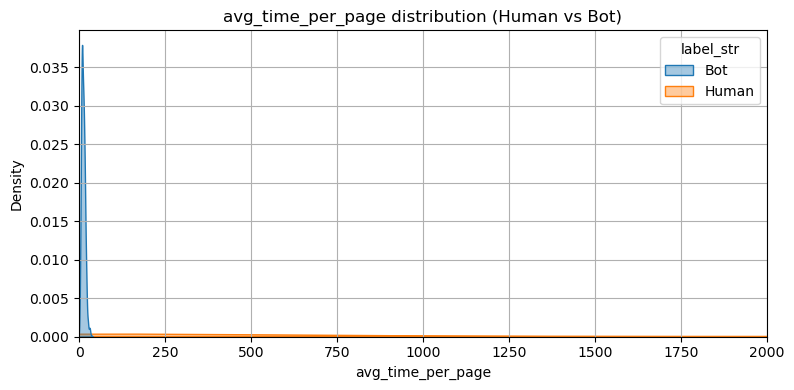

KS test for avg_time_per_page → D = 0.3483, p = 0.0000


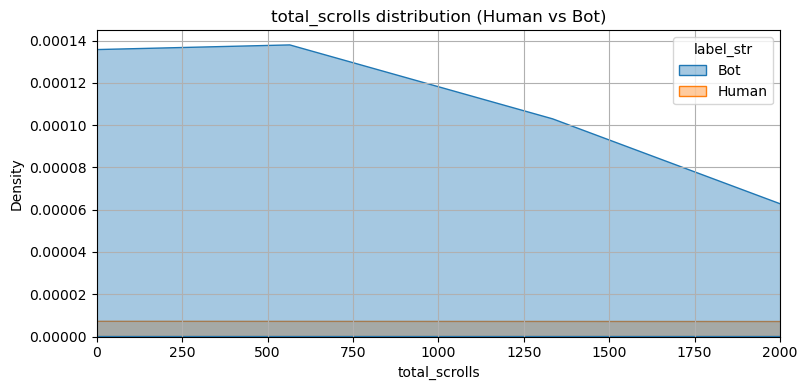

KS test for total_scrolls → D = 0.2776, p = 0.0000


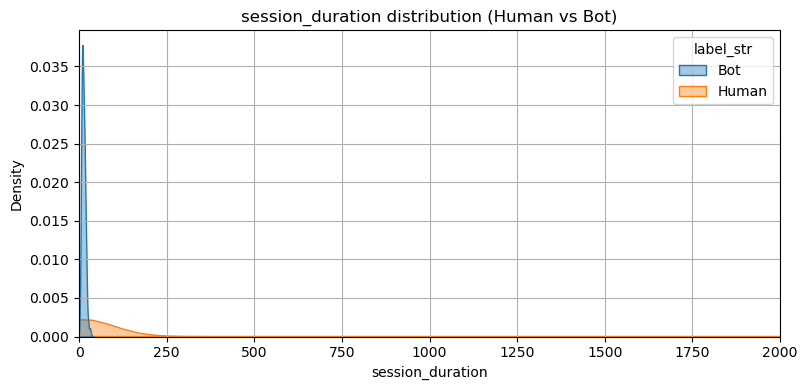

KS test for session_duration → D = 0.4223, p = 0.0000


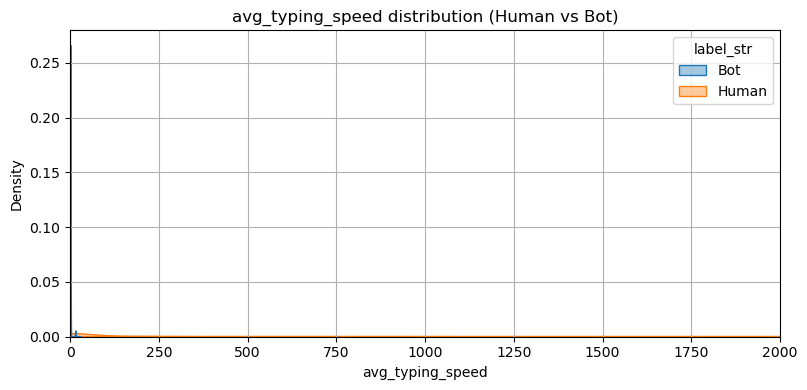

KS test for avg_typing_speed → D = 0.1060, p = 0.0000


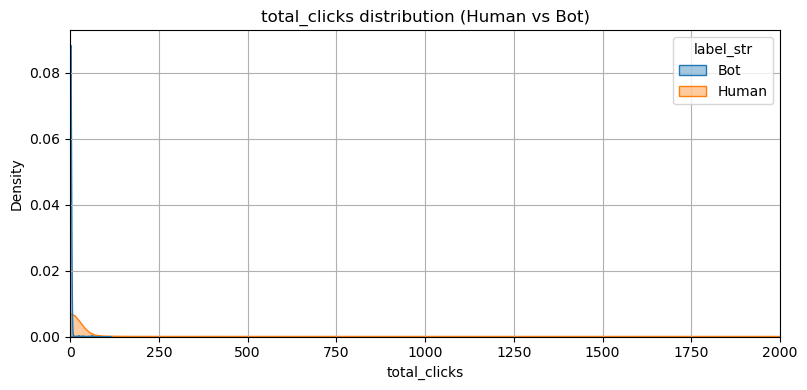

KS test for total_clicks → D = 0.2341, p = 0.0000


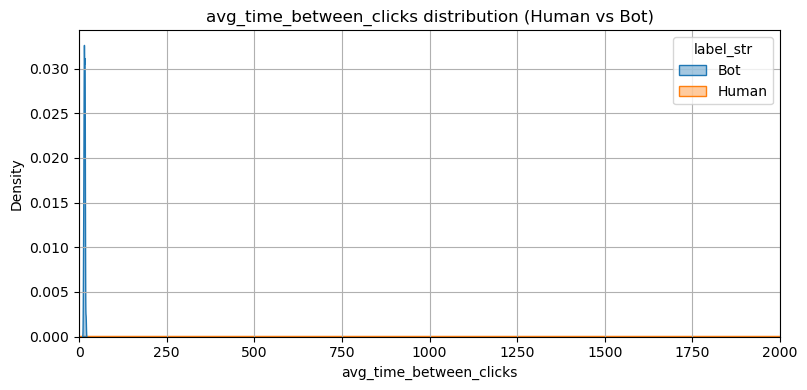

KS test for avg_time_between_clicks → D = nan, p = nan


C:\Users\arelf\AppData\Local\Temp\ipykernel_6428\2525169933.py:30: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='label_str', fill=True, alpha=0.4)


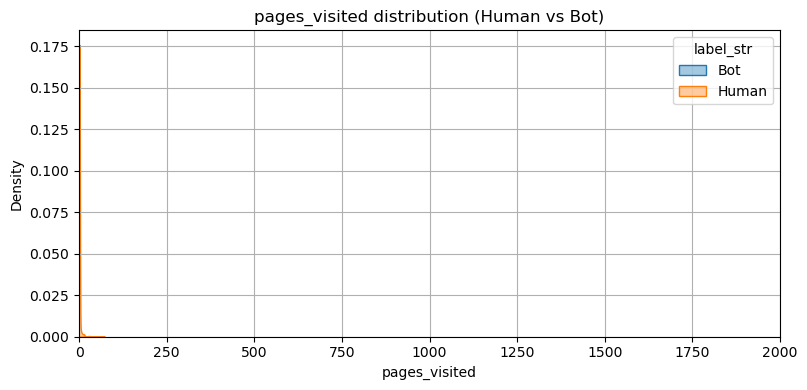

KS test for pages_visited → D = 0.1000, p = 0.0001


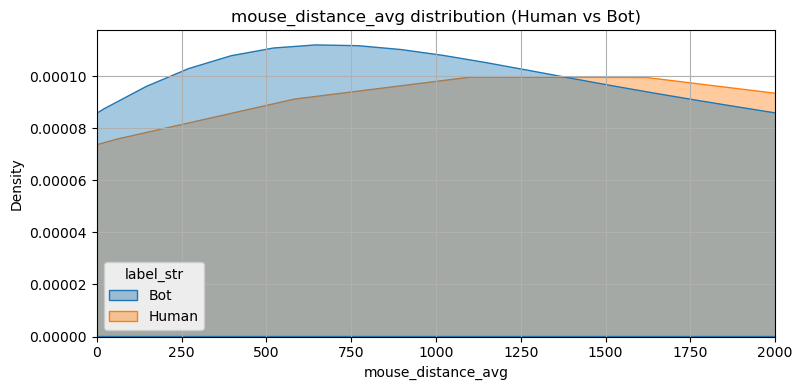

KS test for mouse_distance_avg → D = 0.1894, p = 0.0000


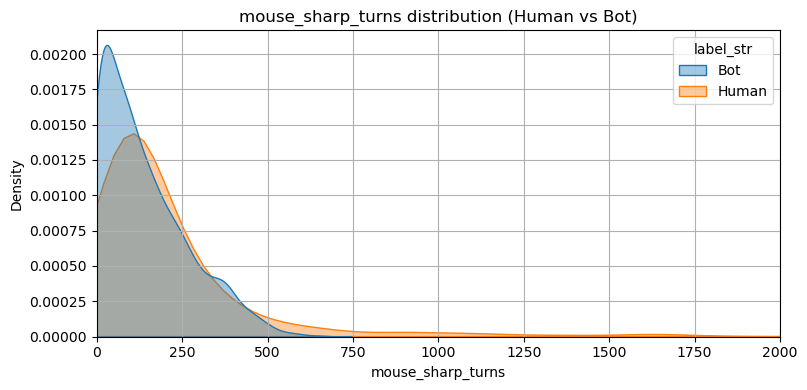

KS test for mouse_sharp_turns → D = 0.1741, p = 0.0000


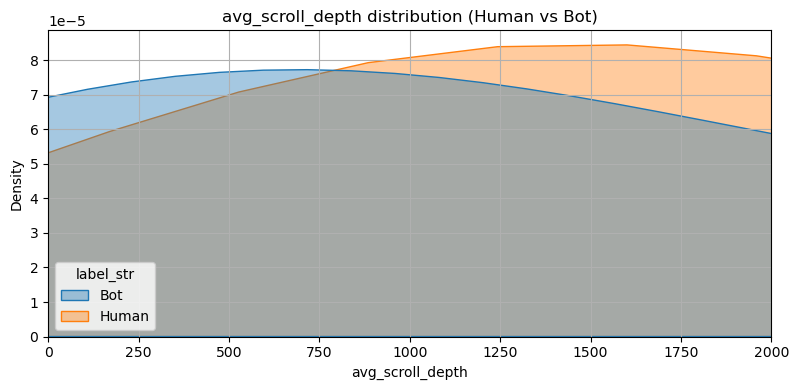

KS test for avg_scroll_depth → D = 0.2270, p = 0.0000


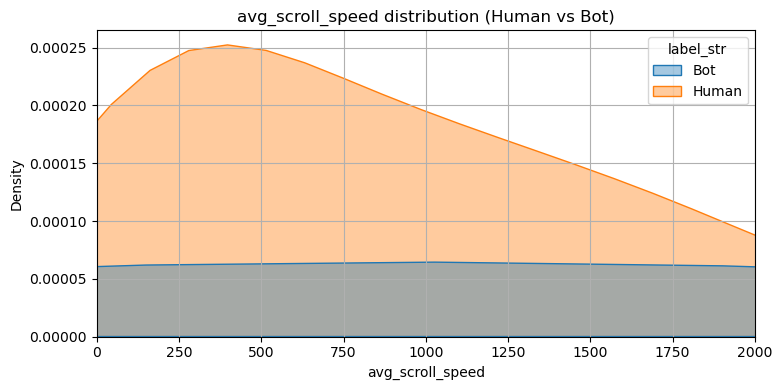

KS test for avg_scroll_speed → D = 0.1772, p = 0.0000


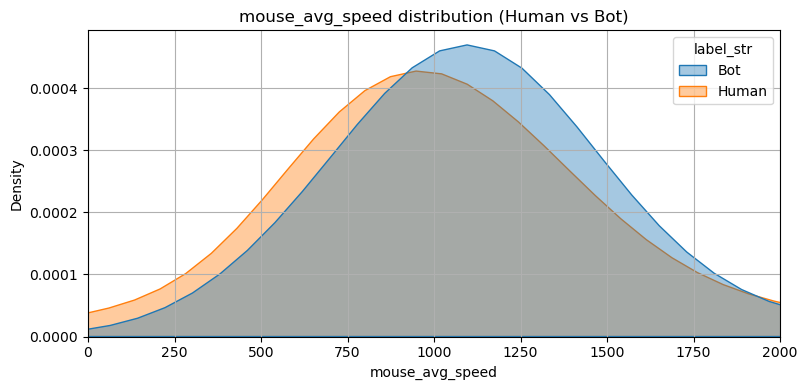

KS test for mouse_avg_speed → D = 0.1352, p = 0.0000


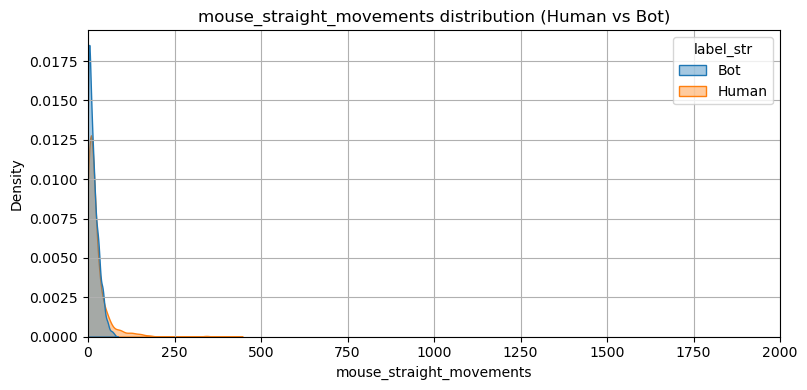

KS test for mouse_straight_movements → D = 0.0831, p = 0.0018


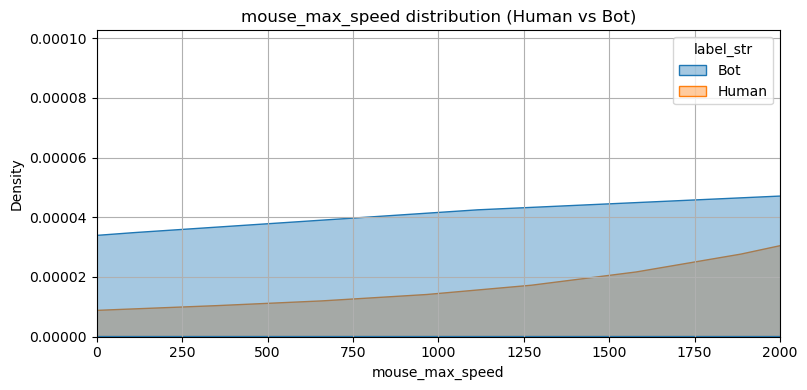

KS test for mouse_max_speed → D = 0.4331, p = 0.0000


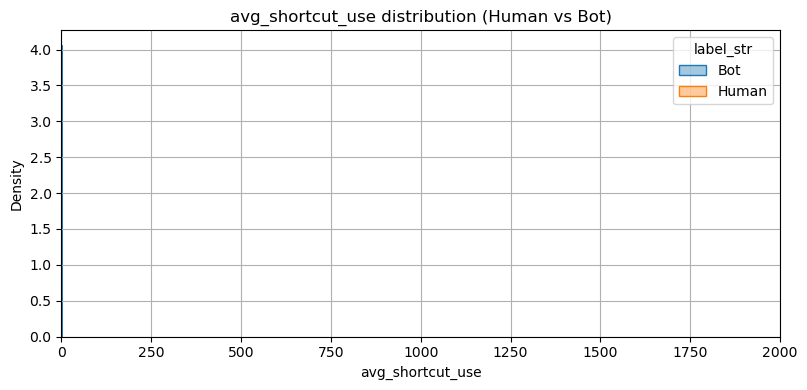

KS test for avg_shortcut_use → D = 0.0631, p = 0.0347


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Load and label
df_puppeteer = pd.read_csv("puppeteer.csv")
df_humans    = pd.read_csv("humans.csv")

df_puppeteer["label"] = 1  # Bot
df_humans["label"]     = 0  # Human

# Combine
df = pd.concat([df_puppeteer, df_humans], ignore_index=True)

# Optional: Replace 0/1 with readable strings for plotting
df['label_str'] = df['label'].map({0: 'Human', 1: 'Bot'})

# Choose a few key features to check
features = [
    "avg_time_per_page","total_scrolls","session_duration","avg_typing_speed",
    "total_clicks","avg_time_between_clicks","pages_visited","mouse_distance_avg",
    "mouse_sharp_turns","avg_scroll_depth","avg_scroll_speed","mouse_avg_speed",
    "mouse_straight_movements","mouse_max_speed","avg_shortcut_use"
]

# Plot distributions + KS test
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=feature, hue='label_str', fill=True, alpha=0.4)
    plt.title(f'{feature} distribution (Human vs Bot)')
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(left=0)
    plt.xlim(0, 2000)  
    plt.show()
    
    # KS test
    ks_stat, p_value = ks_2samp(
        df[df['label'] == 0][feature],
        df[df['label'] == 1][feature]
    )
    print(f"KS test for {feature} → D = {ks_stat:.4f}, p = {p_value:.4f}")


   >>> XGBoost was trained on 12 features
   >>> External data after transform has 12 features
=== External XGBoost ===
              precision    recall  f1-score   support

           0     0.7648    0.9950    0.8648      1000
           1     0.9928    0.6937    0.8167       999

    accuracy                         0.8444      1999
   macro avg     0.8788    0.8443    0.8408      1999
weighted avg     0.8788    0.8444    0.8408      1999

Confusion Matrix (XGB):
[[995   5]
 [306 693]]

=== External Random Forest ===
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1000
           1       0.99      0.77      0.86       999

    accuracy                           0.88      1999
   macro avg       0.90      0.88      0.88      1999
weighted avg       0.90      0.88      0.88      1999

Confusion Matrix (RF):
[[991   9]
 [232 767]]


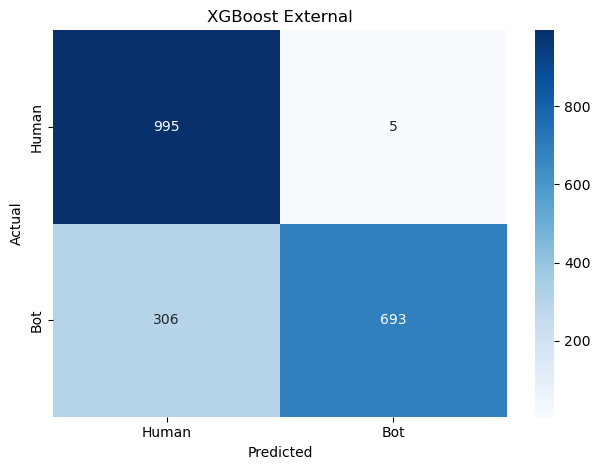

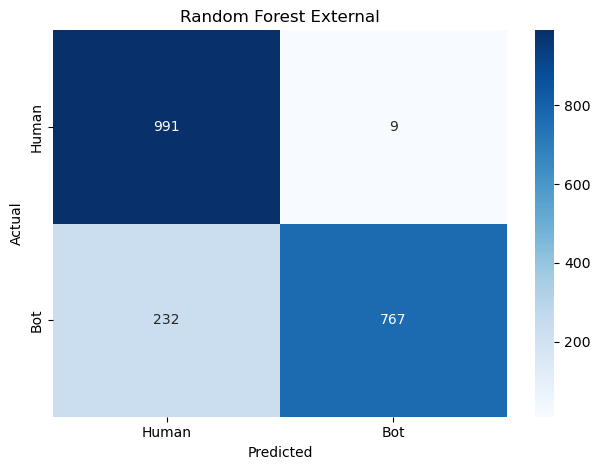

In [ ]:
# Cell 5: External Validation (with humans + bots)

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load external bot + human data
df_bot   = pd.read_csv('playwrightdata.csv')
df_bot['label'] = 1

df_human = pd.read_csv('humans.csv')
df_human['label'] = 0

df_ext = pd.concat([df_human, df_bot], ignore_index=True)

# 2) Drop the same “poorly recorded” columns as before
df_ext = df_ext.drop(columns=[
    "session_id", "mouse_idle_time", "avg_time_between_clicks",
], errors="ignore")

# 3) Align features to training set
y_ext = df_ext['label'].values
X_ext = df_ext.drop(columns='label')
X_ext = X_ext.reindex(columns=X_train.columns, fill_value=0)
X_ext = X_ext.select_dtypes(include='number')

# 4) Winsorize external using train‐set 99th percentile caps
winsor_cols = [
    "avg_time_per_page","total_scrolls","session_duration","avg_typing_speed",
    "total_clicks","avg_time_between_clicks","pages_visited","mouse_distance_avg",
    "mouse_sharp_turns","avg_scroll_depth","avg_scroll_speed","mouse_avg_speed",
    "mouse_straight_movements","mouse_max_speed","avg_shortcut_use"
]
for col in winsor_cols:
    if col in X_train.columns and col in X_ext.columns:
        cap = X_train[col].quantile(0.99)
        X_ext[col] = np.minimum(X_ext[col], cap)

# 5) Transform via your pre-fitted selectors (use .values)
X_ext_arr = X_ext.values
X_ext_xgb = sel_xgb.transform(X_ext_arr)
X_ext_rf  = sel_rf .transform(X_ext_arr)

# ── DEBUG: compare feature‐counts ─────────────────────────
print(f"   >>> XGBoost was trained on {xgb_sel.get_booster().num_features()} features")
print(f"   >>> External data after transform has {X_ext_xgb.shape[1]} features")
# If these differ, something in your alignment/winsorization is dropping or adding columns.

# 6) Predict
#    pass validate_features=False to skip XGBoost's strict shape check
y_pred_xgb = xgb_sel.predict(X_ext_xgb, validate_features=False)
y_pred_rf  = rf_sel .predict(X_ext_rf)

# 7) Print classification reports
print("=== External XGBoost ===")
print(classification_report(y_ext, y_pred_xgb, digits=2))
print("Confusion Matrix (XGB):")
print(confusion_matrix(y_ext, y_pred_xgb))

print("\n=== External Random Forest ===")
print(classification_report(y_ext, y_pred_rf, digits=2))
print("Confusion Matrix (RF):")
print(confusion_matrix(y_ext, y_pred_rf))

# 8) Plot confusion matrices
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Human','Bot'], yticklabels=['Human','Bot'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_cm(y_ext, y_pred_xgb, "XGBoost External")
plot_cm(y_ext, y_pred_rf,  "Random Forest External")


   >>> XGBoost was trained on 12 features
   >>> External data after transform has 12 features
=== External XGBoost ===
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1000
           1       0.99      0.65      0.78      1000

    accuracy                           0.82      2000
   macro avg       0.87      0.82      0.82      2000
weighted avg       0.87      0.82      0.82      2000

Confusion Matrix (XGB):
[[995   5]
 [352 648]]

=== External Random Forest ===
              precision    recall  f1-score   support

           0       0.74      0.99      0.84      1000
           1       0.99      0.65      0.78      1000

    accuracy                           0.82      2000
   macro avg       0.86      0.82      0.81      2000
weighted avg       0.86      0.82      0.81      2000

Confusion Matrix (RF):
[[991   9]
 [355 645]]


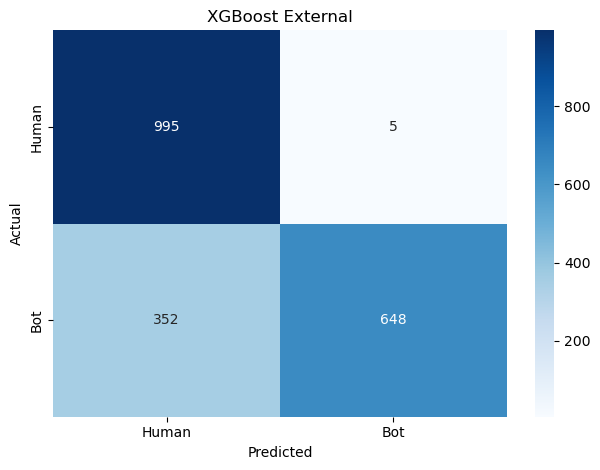

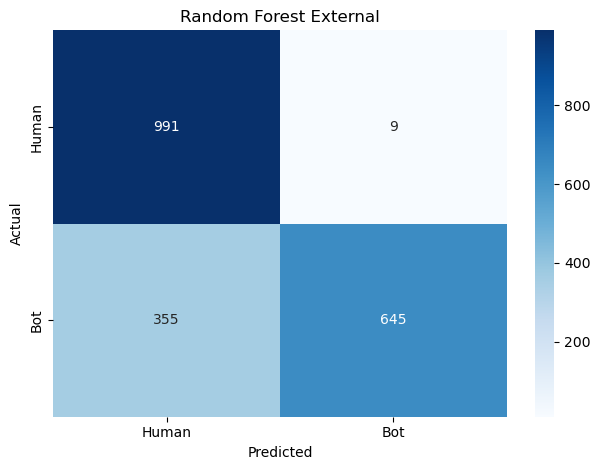

In [15]:
# Cell 5: External Validation (with humans + bots)

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load external bot + human data
df_bot   = pd.read_csv('externalscrapingbot.csv')
df_bot['label'] = 1

df_human = pd.read_csv('humans.csv')
df_human['label'] = 0

df_ext = pd.concat([df_human, df_bot], ignore_index=True)

# 2) Drop the same poorly recorded columns as before
df_ext = df_ext.drop(columns=[
    "session_id", "mouse_idle_time", "avg_time_between_clicks",
], errors="ignore")

# 3) Align features to training set
y_ext = df_ext['label'].values
X_ext = df_ext.drop(columns='label')
X_ext = X_ext.reindex(columns=X_train.columns, fill_value=0)
X_ext = X_ext.select_dtypes(include='number')

# 4) Winsorize external using train‐set 99th percentile caps
winsor_cols = [
    "avg_time_per_page","total_scrolls","session_duration","avg_typing_speed",
    "total_clicks","avg_time_between_clicks","pages_visited","mouse_distance_avg",
    "mouse_sharp_turns","avg_scroll_depth","avg_scroll_speed","mouse_avg_speed",
    "mouse_straight_movements","mouse_max_speed","avg_shortcut_use"
]
for col in winsor_cols:
    if col in X_train.columns and col in X_ext.columns:
        cap = X_train[col].quantile(0.99)
        X_ext[col] = np.minimum(X_ext[col], cap)

# 5) Transform via your pre-fitted selectors (use .values)
X_ext_arr = X_ext.values
X_ext_xgb = sel_xgb.transform(X_ext_arr)
X_ext_rf  = sel_rf .transform(X_ext_arr)

# ── DEBUG: compare feature‐counts ─────────────────────────
print(f"   >>> XGBoost was trained on {xgb_sel.get_booster().num_features()} features")
print(f"   >>> External data after transform has {X_ext_xgb.shape[1]} features")
# If these differ, something in your alignment/winsorization is dropping or adding columns.

# 6) Predict
#    pass validate_features=False to skip XGBoost's strict shape check
y_pred_xgb = xgb_sel.predict(X_ext_xgb, validate_features=False)
y_pred_rf  = rf_sel .predict(X_ext_rf)

# 7) Print classification reports
print("=== External XGBoost ===")
print(classification_report(y_ext, y_pred_xgb, digits=2))
print("Confusion Matrix (XGB):")
print(confusion_matrix(y_ext, y_pred_xgb))

print("\n=== External Random Forest ===")
print(classification_report(y_ext, y_pred_rf, digits=2))
print("Confusion Matrix (RF):")
print(confusion_matrix(y_ext, y_pred_rf))

# 8) Plot confusion matrices
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Human','Bot'], yticklabels=['Human','Bot'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_cm(y_ext, y_pred_xgb, "XGBoost External")
plot_cm(y_ext, y_pred_rf,  "Random Forest External")
